**Verify the Authenticity of the Signature**

Process Data and Train the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Import Libraries ---
# Standard/Data handling libraries
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

# ML/DL utilities and framework (PyTorch, torchvision)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import RMSprop, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T

# Process image
from PIL import Image

# --- Device Setup ---
# Set device to GPU ('cuda') if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#if torch.cuda.is_available():
#    torch.cuda.set_device(0)
#    print(f'Using GPU')
#else:
#    print(f'Using CPU')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Define dataset path and training parameters
IMG_SIZE = (105, 105) # Image size for preprocessing
BATCH_SIZE = 32 # Number of samples per batch

#ROOT_DIR = "/content/drive/MyDrive/signature_data/"
TRAIN_ROOT_DIR = "/content/drive/MyDrive/signature_data/train"
VAL_ROOT_DIR = "/content/drive/MyDrive/signature_data/valid"
TEST_ROOT_DIR = "/content/drive/MyDrive/signature_data/test"

TRAIN_CSV = "/content/drive/MyDrive/signature_data/train_data.csv"
VAL_CSV = "/content/drive/MyDrive/signature_data/valid_data.csv"
TEST_CSV = "/content/drive/MyDrive/signature_data/test_data.csv"

Using GPU: NVIDIA L4


In [ ]:
TRAIN_ROOT_DIR = "/content/drive/MyDrive/signature_data/train"
VAL_ROOT_DIR = "/content/drive/MyDrive/signature_data/valid"
TEST_ROOT_DIR = "/content/drive/MyDrive/signature_data/test"

VAL_FOLDERS = [f"{i:03d}" for i in range(55, 63)]  # 055-062
TEST_FOLDERS = [f"{i:03d}" for i in range(63, 70)]  # 063-069

VAL_FORG_FOLDERS = [f"{f}_forg" for f in VAL_FOLDERS]
TEST_FORG_FOLDERS = [f"{f}_forg" for f in TEST_FOLDERS]

def move_folders(folders, src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for folder in folders:
        src_path = os.path.join(src_dir, folder)
        dst_path = os.path.join(dst_dir, folder)
        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)
            print(f"Moved {src_path} -> {dst_path}")
        else:
            print(f"Folder {src_path} does not exist!")

move_folders(VAL_FOLDERS + VAL_FORG_FOLDERS, TRAIN_ROOT_DIR, VAL_ROOT_DIR)
move_folders(TEST_FOLDERS + TEST_FORG_FOLDERS, TRAIN_ROOT_DIR, TEST_ROOT_DIR)

Folder /content/drive/MyDrive/signature_data/train/055 does not exist!
Folder /content/drive/MyDrive/signature_data/train/056 does not exist!
Folder /content/drive/MyDrive/signature_data/train/057 does not exist!
Folder /content/drive/MyDrive/signature_data/train/058 does not exist!
Folder /content/drive/MyDrive/signature_data/train/059 does not exist!
Folder /content/drive/MyDrive/signature_data/train/060 does not exist!
Folder /content/drive/MyDrive/signature_data/train/061 does not exist!
Folder /content/drive/MyDrive/signature_data/train/062 does not exist!
Folder /content/drive/MyDrive/signature_data/train/055_forg does not exist!
Folder /content/drive/MyDrive/signature_data/train/056_forg does not exist!
Folder /content/drive/MyDrive/signature_data/train/057_forg does not exist!
Folder /content/drive/MyDrive/signature_data/train/058_forg does not exist!
Folder /content/drive/MyDrive/signature_data/train/059_forg does not exist!
Folder /content/drive/MyDrive/signature_data/train/0

In [ ]:
df = pd.read_csv(TRAIN_CSV, header=None)

val_ids = [f"{i:03d}" for i in range(55, 63)]  # 055-062
test_ids = [f"{i:03d}" for i in range(63, 70)] # 063-069

def filter_by_ids(df, ids):
    """Match the rows where the first or second column starts with the specified ID"""
    return df[df[0].str.startswith(tuple(ids)) | df[1].str.startswith(tuple(ids))]

df_val = filter_by_ids(df, val_ids)
df_test = filter_by_ids(df, test_ids)

df_train_new = df.drop(df_val.index).drop(df_test.index)

df_val.to_csv(VAL_CSV, index=False, header=False)
df_test.to_csv(TEST_CSV, index=False, header=False)
df_train_new.to_csv(TRAIN_CSV, index=False, header=False)

print(f"Valid data: {len(df_val)} row → {VAL_CSV}")
print(f"Test data: {len(df_test)} row → {TEST_CSV}")
print(f"new Train data: {len(df_train_new)} row → {TRAIN_CSV}")


Valid data: 2160 row → /content/drive/MyDrive/signature_data/valid_data.csv
Test data: 1788 row → /content/drive/MyDrive/signature_data/test_data.csv
new Train data: 19258 row → /content/drive/MyDrive/signature_data/train_data.csv


In [ ]:
def collect_distances(model, data_loader):
        """Calculate the distances"""
        model.eval()
        all_distances = []
        all_labels = []

        device = next(model.parameters()).device

        # Calculate the the distance without update the weights
        with torch.no_grad():
            for (img0, img1), labels in tqdm(data_loader, desc="Collecting distances", dynamic_ncols=True):
                img0, img1 = img0.to(model.device), img1.to(model.device)
                output1, output2 = model(img0, img1)

                # Compute the Euclidean distances
                distances = F.pairwise_distance(output1, output2)
                all_distances.extend(distances.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        return np.array(all_distances), np.array(all_labels)

In [ ]:
def plot_distance_distribution(model, data_loader, flag, epoch = 0, threshold=None):
    """Plot the distribution of the instances with a threshold line."""
    distances, labels = collect_distances(model, data_loader)

    # Convert distances to numpy array and handle infinities
    distances = np.asarray(distances)
    distances = np.where(np.isinf(distances), np.nan, distances)

    labels = labels.astype(int)

    mask = ~np.isnan(distances)
    distances = distances[mask]
    labels = labels[mask]

    plt.figure(figsize=(10, 6))

    # Plot histograms, ignoring NaN values
    sns.histplot(distances[labels == 0], color='green', label='Genuine Pairs', kde=False, bins=40, stat='probability')
    sns.histplot(distances[labels == 1], color='red', label='Forged Pairs', kde=False, bins=40, stat='probability')

    # Add a vertical line for the threshold
    if threshold is not None:
        plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold:.3f}')

    # Labels and title
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Ratio")
    plt.yscale('log')  # Compress tall peaks
    #plt.yticks([])  # removes y-axis ticks
    #plt.ylabel('')  # removes y-axis label (optional)

    title = f'Train Distance Distribution after Epoch {epoch}' if flag == 0 else "Test Distance Distribution"
    filename = f"Train_Distance_Distribution_Epoch_{epoch}.png" if flag == 0 else "Test_Distance_Distribution.png"

    plt.title(title)
    plt.legend()

    # Save and show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
    plt.show()
    plt.close()  # Close the figure to free memory


def plot_loss_accu(history, filename="training_overtime.png"):
    """ Plot the change in loss and accuracy while training."""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    train_loss = history.get('train_loss', [])

    #plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], marker='o', label='Train Loss')
    plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    if train_loss:
        plt.title(f"Training Loss (min={min(train_loss):.4f})")
    else:
        plt.title('Training Loss')

    plt.legend()

    plt.subplot(1, 2, 2)

    train_acc = history.get('train_acc', [])

    #plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], marker='o', label='Train Accuracy')
    plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label='Train Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    if train_acc:
        plt.title(f"Training Accuracy (max={max(train_acc):.2%})")
    else:
        plt.title('Training Accuracy')

    #plt.title('Training Accuracy')
    plt.legend()

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# Dataset class
class SiameseCSVDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = T.Compose([
            T.Grayscale(),
            T.Resize(IMG_SIZE),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_path = f"{self.root_dir}/{self.df.iloc[idx, 0]}"
        img2_path = f"{self.root_dir}/{self.df.iloc[idx, 1]}"
        label = int(self.df.iloc[idx, 2])

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return (img1, img2), torch.tensor(label, dtype=torch.float32)

In [ ]:
# Creat Dataset and DataLoader
wrapped_dataset_train = SiameseCSVDataset(TRAIN_CSV, TRAIN_ROOT_DIR)
train_loader = DataLoader(
    wrapped_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    persistent_workers=True
)

# val_loader
wrapped_dataset_val = SiameseCSVDataset(VAL_CSV, VAL_ROOT_DIR)
val_loader = DataLoader(
    wrapped_dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    persistent_workers=True
)

# test_loader
wrapped_dataset_test = SiameseCSVDataset(TEST_CSV, TEST_ROOT_DIR)
test_loader = DataLoader(
    wrapped_dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    persistent_workers=True
)

# check
#for (img1, img2), labels in train_loader:
#    print(img1.shape, img2.shape, labels)
#    break

for loader_name, loader in [("train", train_loader), ("valid", val_loader), ("test", test_loader)]:
    (img1, img2), labels = next(iter(loader))
    print(f"{loader_name} -> {img1.shape}, {img2.shape}, {labels}")


train -> torch.Size([32, 1, 105, 105]), torch.Size([32, 1, 105, 105]), tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.])
valid -> torch.Size([32, 1, 105, 105]), torch.Size([32, 1, 105, 105]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
test -> torch.Size([32, 1, 105, 105]), torch.Size([32, 1, 105, 105]), tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.])


In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function for similarity learning.
    This loss function is particularly useful when training models to learn embeddings
    where similar pairs of inputs are mapped close together in the embedding space,
    and dissimilar pairs are mapped far apart.
    """
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Compute contrastive loss using Euclidean Distance."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [ ]:
class SiameseNetwork(nn.Module):
    """Siamese network for signature verification."""
    def __init__(self, device=None, lr=1e-4, from_file=None, embedding_size=256):
        """
        Initializes the SignatureRCNN model.

        Args:
            device (torch.device, optional): Device to use for computation (CPU or CUDA). Defaults to CUDA if available, otherwise CPU.
            lr (float, optional): Learning rate for the optimizer. Defaults to 1e-4.
            from_file (str, optional): Path to a pre-trained model file to load. Defaults to None.
            embedding_size (int): Size of the final feature vector.
        """
        super(SiameseNetwork, self).__init__()
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Define convolutional layers for feature extraction
        self.cnn = nn.Sequential(
            # Block 1: 1 input channel (grayscale), 64 output channels
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(), # Replace ReLU
            nn.BatchNorm2d(64), # Add BatchNorm to stabalize
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), # Stride=2 for downsampling, (replaces MaxPool)

            # Block 2: 64 input channels, 128 output channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),

            # Block 3: 128 input channels, 256 output channels
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),

            # Block 4: 256 input channels, 512 output channels
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),

            nn.AdaptiveAvgPool2d((1, 1)) # Replace flattening, less overfit, more intepretable features
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, embedding_size)
        )

        # Set up optimizer and criterion
        self.criterion = ContrastiveLoss(margin=1.5)
        self.optimizer = AdamW(self.parameters(), lr=lr, weight_decay=1e-4)

        # Load the model weight if exist
        if from_file and os.path.exists(from_file):
            self.load_from_file(from_file)
        self.to(self.device)

    def forward_once(self, x):
        """Pass input through the feature extractor."""
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        """Compute embeddings for both images in the pair."""
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def load_from_file(self, file_path):
        """Load the model weights from a pre-trained file"""
        checkpoint = torch.load(file_path, map_location=self.device, weights_only=True)
        self.cnn.load_state_dict(checkpoint['cnn'])
        self.fc.load_state_dict(checkpoint['fc'])
        print(f"Loaded weights from {file_path}")

    def save_to_file(self, file_path):
        """Save the model weights"""
        torch.save({
            'cnn': self.cnn.state_dict(),
            'fc': self.fc.state_dict()
        }, file_path)
        print("Saved the new model")

    def compute_accuracy(self, output1, output2, labels, threshold=0.5):
        """Compute accuracy based on Euclidean distance threshold."""
        distances = F.pairwise_distance(output1, output2)
        predictions = (distances > threshold).float()
        correct = (predictions == labels).sum().item()
        return correct, len(labels)

    def train_one_epoch(self, train_loader, epoch_count, total_epoch=None):
        """ Iterate through the training data to update weight """
        self.train()
        epoch_train_loss = 0.0     # loss after each epoch
        train_correct = 0          # number of correct samples
        total_train_samples = 0    # total number of samples

        for (img0, img1), label in tqdm(train_loader, desc=f"[Train] Epoch {epoch_count} / {total_epoch}", dynamic_ncols=True):
            # Move images and labels to the appropriate device (GPU/CPU)
            img0, img1, label = img0.to(self.device), img1.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() # Reset gradients
            output1, output2 = self(img0, img1) # Forward pass

            loss_contrastive = self.criterion(output1, output2, label) # Calculate loss function
            loss_contrastive.backward() # Backpropagation
            self.optimizer.step() # Update model parameters
            # After update weights
            epoch_train_loss += loss_contrastive.item()   # Accumulate loss
            correct, total = self.compute_accuracy(output1, output2, label)  # Compute accuracy
            train_correct += correct
            total_train_samples += total

        # Calculate average loss and training accuracy
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = train_correct / total_train_samples
        return avg_train_loss, train_accuracy

    #def train_model(self, train_loader, epochs=25, file_path="Siamese_savefile.pth", plot_every=5):
    def train_model(self, train_loader, val_loader, epochs=25, file_path="Siamese_savefile.pth", plot_every=5):

        """ Iterate through all epochs to update weight """
        # Learning rate scheduler to adjust learning rate based on validation loss
        scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
        # Dictionary to store training history
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

        for epoch in range(1, epochs+1):
            # Train for one epoch
            avg_train_loss, train_accuracy = self.train_one_epoch(train_loader, epoch, epochs)
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_accuracy)

            # ======== Validation ========
            self.eval()
            val_loss_total, val_correct, val_samples = 0.0, 0, 0
            with torch.no_grad():
                for (img0, img1), label in val_loader:
                    img0, img1, label = img0.to(self.device), img1.to(self.device), label.to(self.device)
                    output1, output2 = self(img0, img1)
                    loss = self.criterion(output1, output2, label)
                    val_loss_total += loss.item()
                    correct, total = self.compute_accuracy(output1, output2, label)
                    val_correct += correct
                    val_samples += total

            avg_val_loss = val_loss_total / len(val_loader)
            val_accuracy = val_correct / val_samples
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_accuracy)

            # Update learning rate based on loss
            #scheduler.step(avg_train_loss)
            scheduler.step(avg_val_loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            history['lr'].append(current_lr)

            # Print epoch summary
            #print(f"Epoch [{epoch}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Train Acc: {train_accuracy:.4f}, LR: {current_lr:.6f}")
            print(f"Epoch [{epoch}/{epochs}] - "
              f"Train Loss: {avg_train_loss:.6f}, Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {val_accuracy:.4f} | "
              f"LR: {current_lr:.6f}")

            # Plot the distribution of Euclidean distances on Train set
            if plot_every != -1:
                if (epoch-1) % plot_every == 0 and epoch != 1:
                    plot_distance_distribution(self, train_loader, 0, epoch)

            else:
                if epoch == epochs - 1:
                    plot_distance_distribution(self, train_loader, 0, epoch)

        # Plot training loss and accuracy over epochs
        plot_loss_accu(history)
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        self.save_to_file(file_path) # Save the model after trained

[Train] Epoch 1 / 1:   0%|          | 0/602 [00:00<?, ?it/s]

Epoch [1/1] - Train Loss: 0.093013, Train Acc: 0.9347 | Val Loss: 0.176635, Val Acc: 0.9088 | LR: 0.000100


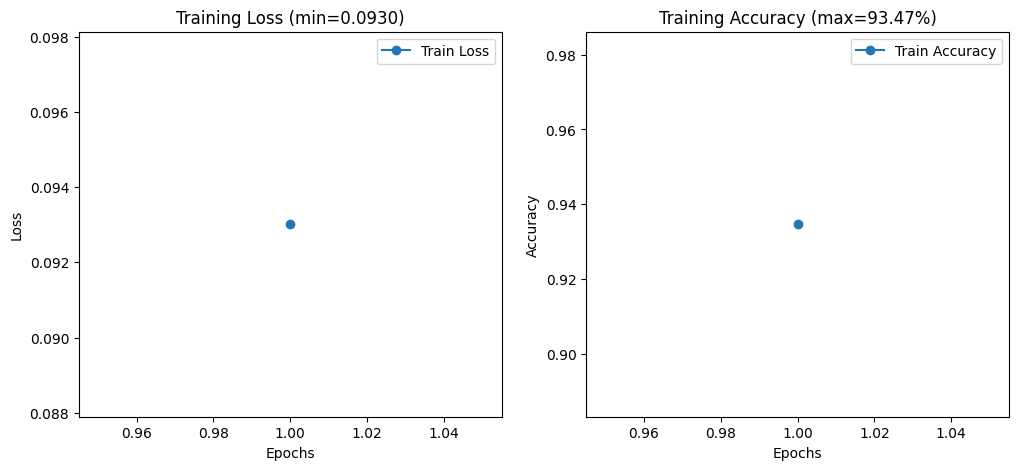

Saved the new model


In [ ]:
# Initialize and training the model
model = SiameseNetwork(embedding_size=256)
# model = SiameseNetwork(embedding_size=256, from_file='the-old-model.pt')

#epochs = 15
epochs = 1
#model_save_path = '/content/drive/MyDrive/signature_data/runs/verify/siamese_1.pt'
model_save_path = '/content/drive/MyDrive/signature_data/runs/hyperparameter_tuning/siamese_1.pt'

model.train_model(train_loader, val_loader, epochs=epochs, file_path=model_save_path, plot_every=-1)

In [ ]:
def evaluate_and_log_errors(model, data_loader, threshold=0.5):
    """Evaluates the Siamese Network and logs misclassified samples."""
    model.eval()
    true_labels = []
    pred_labels = []
    misclassified_samples = []

    all_distances = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for (img0, img1), labels in tqdm(data_loader, desc="Evaluating", dynamic_ncols=True):
            img0, img1 = img0.to(model.device), img1.to(model.device)
            output1, output2 = model(img0, img1)

            # Compute Euclidean distance
            distances = F.pairwise_distance(output1, output2)

            all_distances.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            predictions = (distances > threshold).float()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

            # Log misclassified cases
            for i in range(len(labels)):
                if labels[i].item() != predictions[i].item():
                    misclassified_samples.append((img0[i].cpu(), img1[i].cpu(), labels[i].item(), predictions[i].item()))

    """ Plot Distribution of Euclidean distances on Test set"""
    distances, labels = np.array(all_distances), np.array(all_labels)
    # Compute confusion matrix

    distances = np.asarray(distances)
    distances = np.where(np.isinf(distances), np.nan, distances)

    plt.figure(figsize=(10, 6))

    # Plot histograms, ignoring NaN values
    sns.histplot(distances[labels == 0], color='green', label='Genuine Pairs', kde=True, bins=40, stat='probability')
    sns.histplot(distances[labels == 1], color='red', label='Forged Pairs', kde=True, bins=40, stat='probability')

    # Add a vertical line for the threshold
    if threshold is not None:
        plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold:.3f}')

    # Labels and title
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Ratio")
    plt.yscale('log')  # Compress tall peaks
    plt.yticks([])  # removes y-axis ticks
    plt.ylabel('')  # removes y-axis label (optional)

    title = "Test Distance Distribution"
    filename = "Test_Distance_Distribution.png"

    plt.title(title)
    plt.legend()

    # Save and show the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
    plt.show()

    """ Plot confusion matrix """
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Genuine", "Forged"], yticklabels=["Genuine", "Forged"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Signature Verification")
    # plt.savefig("cm.png", dpi = 300, bbox_inches='tight')
    plt.show()

    print(f"Number of misclassified samples: {len(misclassified_samples)}")

    # Save or display the misclassified samples
    return misclassified_samples

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

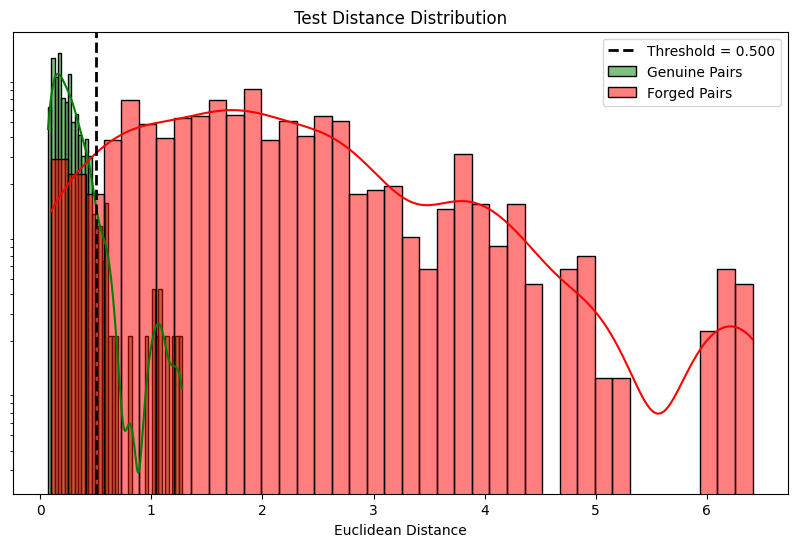

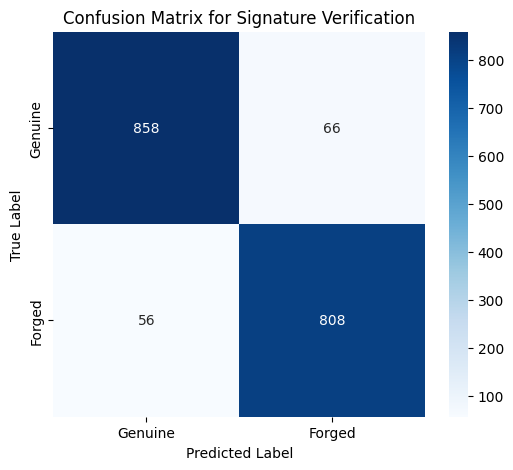

Number of misclassified samples: 122


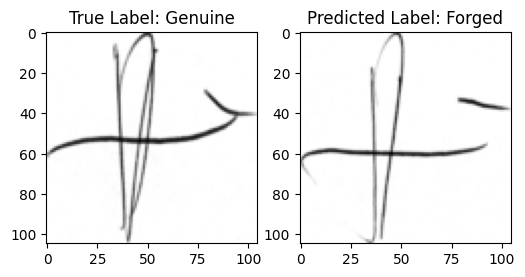

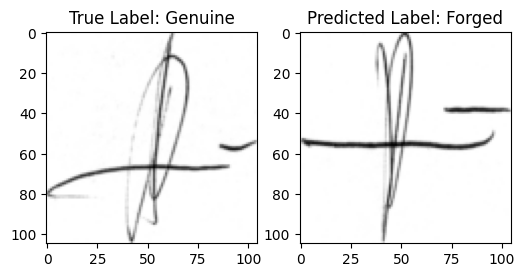

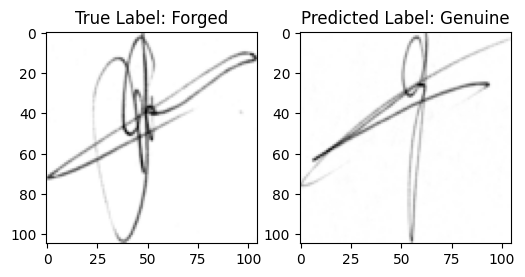

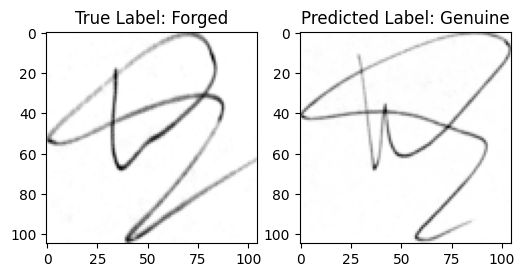

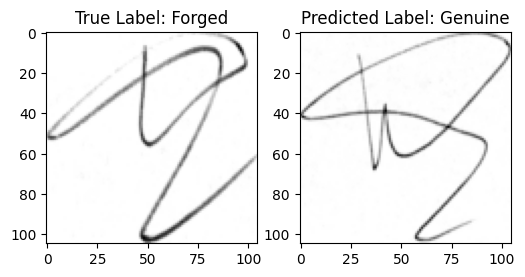

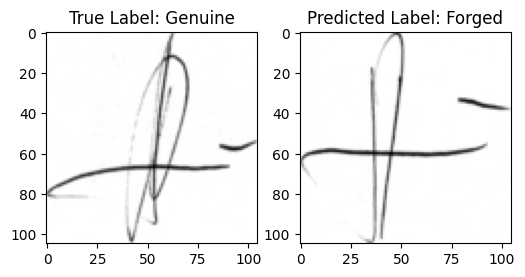

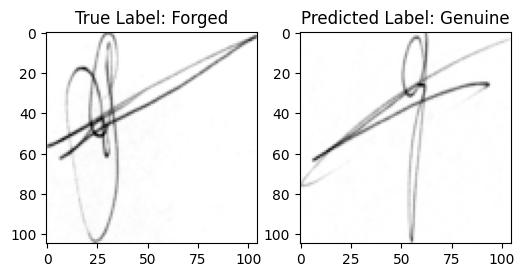

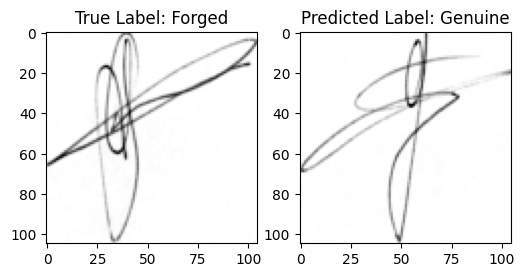

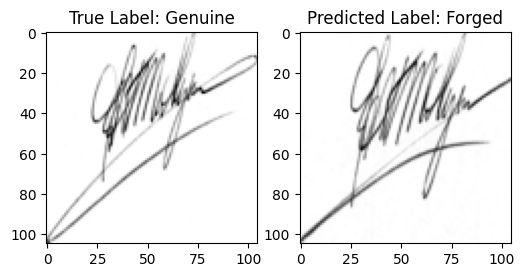

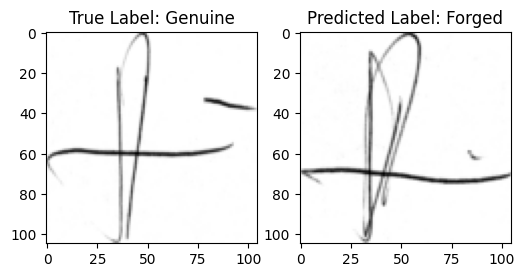

In [ ]:
# Run function and retrieve misclassified samples
misclassified_samples = evaluate_and_log_errors(model, test_loader, threshold=0.5)

# Display the misclassified image pair
for idx, (img0, img1, true_label, pred_label) in enumerate(misclassified_samples[:10]):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Convert labels to meaningful text
    true_label_text = "Genuine" if true_label == 0 else "Forged"
    pred_label_text = "Genuine" if pred_label == 0 else "Forged"
    # Plot first image
    axes[0].imshow(img0.squeeze(), cmap="gray")
    axes[0].set_title(f"True Label: {true_label_text}")
    # Plot second image
    axes[1].imshow(img1.squeeze(), cmap="gray")
    axes[1].set_title(f"Predicted Label: {pred_label_text}")
    plt.show()